In [5]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        filepath = os.path.join(dirname, filename)
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/726-sentimentdata/2022_CS_726_SentimentDataSet_.xlsx


# DataSet

(40200, 9)
   Sentence Number      Drama Name  Episode Number  \
0                1          Fitoor              38   
1                2            Alif               3   
2                3          Mumkin              21   
3                4  Mein hari piya              57   
4                5          Fitoor               4   

                                  Youtube Link Start_TimeSpan End_TimeSpan  \
0  https://www.youtube.com/watch?v=gY6ayspZuZQ          12:42        12:47   
1  https://www.youtube.com/watch?v=0FtEVkM74XY          31:06        31:11   
2  https://www.youtube.com/watch?v=xd8DM6Qd36A          25:54        25:59   
3  https://www.youtube.com/watch?v=a9_ccaK0580          02:10        02:15   
4  https://www.youtube.com/watch?v=XNrKY24tNBY          14:12        14:15   

                                            Sentence  \
0                            I have really hurt you,   
1                                     You are lying.   
2                    And th

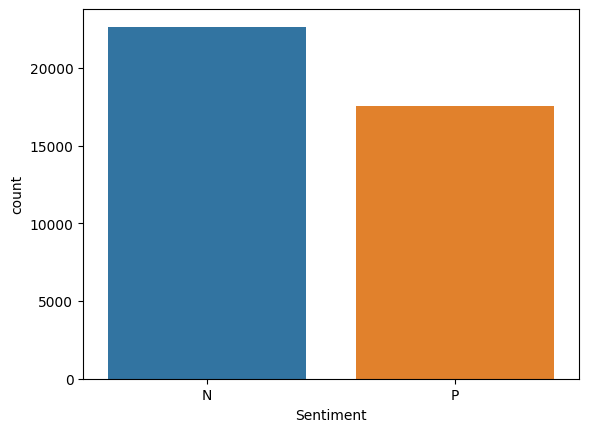

In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns
# Load the labeled dataset

# df = pd.read_excel('/kaggle/input/726sentimentdataset/2022_CS_726_SentimentDataSet.xlsx')
df = pd.read_excel('/kaggle/input/726-sentimentdata/2022_CS_726_SentimentDataSet_.xlsx')

print(df.shape)
sns.countplot( x = 'Sentiment', data = df )

print(df.head(5))

# Splitting

In [7]:

train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['Sentiment'], random_state=42)
train_df.to_excel('train_data.xlsx', index=False)
test_df.to_excel('test_data.xlsx', index=False)

print(f" Train size: {len(train_df)}")
print(f" Test size: {len(test_df)}")
print(" Files saved: train_data.xlsx and test_data.xlsx")

 Train size: 32160
 Test size: 8040
 Files saved: train_data.xlsx and test_data.xlsx


# Training

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
import lightgbm as lgb
from sklearn.metrics import classification_report
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Load saved train/test files
train_df = pd.read_excel('train_data.xlsx')
test_df = pd.read_excel('test_data.xlsx')

# Step 2: Encode Sentiment labels (P/N)
le = LabelEncoder()
train_df['encoded'] = le.fit_transform(train_df['Sentiment'])
test_df['encoded'] = le.transform(test_df['Sentiment'])

# Step 3: TF-IDF Vectorization on text
vectorizer = TfidfVectorizer(max_features=50000)
X_train = vectorizer.fit_transform(train_df['USentence'])
X_test = vectorizer.transform(test_df['USentence'])


# XGBoost Training
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, train_df['encoded'])

# Logistic Regression Training
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train, train_df['encoded'])

# Naive Bayes Training
nb_model = MultinomialNB()
nb_model.fit(X_train, train_df['encoded'])

# Support Vector Machine Training
svm_model = LinearSVC()
svm_model.fit(X_train, train_df['encoded'])


# LightGBM Training (Latest Model)
lgb_model = lgb.LGBMClassifier(n_estimators=100, random_state=42)
lgb_model.fit(X_train, train_df['encoded'])

# Testing the models
models = {
    "Logistic Regression": lr_model,
    "Naive Bayes": nb_model,
    "SVM": svm_model,
    "XGBoost": xgb_model,
    "LightGBM": lgb_model 
}



[LightGBM] [Info] Number of positive: 14030, number of negative: 18130
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.109124 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 44750
[LightGBM] [Info] Number of data points in the train set: 32160, number of used features: 946
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.436256 -> initscore=-0.256370
[LightGBM] [Info] Start training from score -0.256370


# Testing

In [11]:

model_accuracies = {}

# Step 1: Evaluate Accuracy of All Models
for model_name, model in models.items():
    
    # Predict the encoded sentiment labels
    test_df[f'{model_name}_Predicted_encoded'] = model.predict(X_test)
    
    # Inverse transform to get the original sentiment labels
    test_df[f'{model_name}_Predicted'] = le.inverse_transform(test_df[f'{model_name}_Predicted_encoded'])
    
    # Calculate accuracy
    accuracy = accuracy_score(test_df['encoded'], test_df[f'{model_name}_Predicted_encoded'])
    model_accuracies[model_name] = accuracy  # Store accuracy in dictionary
    print(f" {model_name} Accuracy: {accuracy:.2f}")

# Step 2: Print Classification Reports After Accuracy
for model_name, model in models.items():
    # Classification Report
    print(f"\n📊 {model_name} Classification Report:\n")
    print(classification_report(test_df['encoded'], test_df[f'{model_name}_Predicted_encoded'], target_names=le.classes_))
    
    # Save predictions to Excel
    test_df[['USentence', 'Sentiment', f'{model_name}_Predicted']].to_excel(f'{model_name}_test_result_with_predictions.xlsx', index=False)



 Logistic Regression Accuracy: 0.93
 Naive Bayes Accuracy: 0.89
 SVM Accuracy: 0.94
 XGBoost Accuracy: 0.90
 LightGBM Accuracy: 0.90

📊 Logistic Regression Classification Report:

              precision    recall  f1-score   support

           N       0.93      0.94      0.94      4532
           P       0.92      0.91      0.92      3508

    accuracy                           0.93      8040
   macro avg       0.93      0.93      0.93      8040
weighted avg       0.93      0.93      0.93      8040


📊 Naive Bayes Classification Report:

              precision    recall  f1-score   support

           N       0.88      0.94      0.91      4532
           P       0.91      0.84      0.87      3508

    accuracy                           0.89      8040
   macro avg       0.90      0.89      0.89      8040
weighted avg       0.90      0.89      0.89      8040


📊 SVM Classification Report:

              precision    recall  f1-score   support

           N       0.95      0.94      0.

In [12]:
import pandas as pd

# Sample Urdu Sentences
urdu_sentences = [
    "یہ پروڈکٹ واقعی بہت شاندار ہے",         # Positive
    "مجھے یہ بالکل پسند نہیں آیا",            # Negative
    "یہ تجربہ بہت مایوس کن تھا",               # Negative
    "سروس بہت اچھی تھی",                       # Positive
    "کوالٹی زبردست ہے اور قیمت مناسب ہے",      # Positive
    "پیسے ضائع کیے، کوئی فائدہ نہیں ہوا",      # Negative
    "مجھے اس سے بہتر کی توقع تھی",             # Negative
    "بہت خوشی ہوئی، شکریہ",                    # Positive
    "ڈلیوری وقت پر ہوئی، بہت اچھا لگا",        # Positive
    "افسوس ہوا، یہ کام نہیں آیا"               # Negative
]

# Create DataFrame
urdu_df = pd.DataFrame({'USentence': urdu_sentences})

# Preprocess: Vectorize using your fitted vectorizer
X_new = vectorizer.transform(urdu_df['USentence'])  # Use the same vectorizer you trained earlier

# Predict and Print
print("📢 Urdu Sentiment Predictions by Each Model:\n")

for model_name, model in models.items():
    # Predict encoded sentiment
    predicted_encoded = model.predict(X_new)
    # Decode to original labels
    predicted_labels = le.inverse_transform(predicted_encoded)
    
    print(f"🟢 {model_name} Predictions:")
    for i, sentence in enumerate(urdu_sentences):
        print(f" - \"{sentence}\" : {predicted_labels[i]}")
    print("\n" + "-"*60 + "\n")


📢 Urdu Sentiment Predictions by Each Model:

🟢 Logistic Regression Predictions:
 - "یہ پروڈکٹ واقعی بہت شاندار ہے" : P
 - "مجھے یہ بالکل پسند نہیں آیا" : N
 - "یہ تجربہ بہت مایوس کن تھا" : N
 - "سروس بہت اچھی تھی" : P
 - "کوالٹی زبردست ہے اور قیمت مناسب ہے" : N
 - "پیسے ضائع کیے، کوئی فائدہ نہیں ہوا" : N
 - "مجھے اس سے بہتر کی توقع تھی" : P
 - "بہت خوشی ہوئی، شکریہ" : P
 - "ڈلیوری وقت پر ہوئی، بہت اچھا لگا" : P
 - "افسوس ہوا، یہ کام نہیں آیا" : N

------------------------------------------------------------

🟢 Naive Bayes Predictions:
 - "یہ پروڈکٹ واقعی بہت شاندار ہے" : P
 - "مجھے یہ بالکل پسند نہیں آیا" : N
 - "یہ تجربہ بہت مایوس کن تھا" : N
 - "سروس بہت اچھی تھی" : P
 - "کوالٹی زبردست ہے اور قیمت مناسب ہے" : N
 - "پیسے ضائع کیے، کوئی فائدہ نہیں ہوا" : N
 - "مجھے اس سے بہتر کی توقع تھی" : N
 - "بہت خوشی ہوئی، شکریہ" : P
 - "ڈلیوری وقت پر ہوئی، بہت اچھا لگا" : P
 - "افسوس ہوا، یہ کام نہیں آیا" : N

------------------------------------------------------------

🟢 SVM Predictions:
 - "یہ